In [4]:
import os
import torch
import cv2
import numpy as np
from skimage import filters
from drunet.drunet import UNetRes
from utils import uint2single, single2tensor4, test_onesplit, tensor2uint, heal_image

### Load the DRUNet Model

In [53]:
# Initialize model parameters
model_path = './drunet/drunet_gray.pth'
n_channels = 1
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
noise_level_model = 5

# Load the DRUNet model
model = UNetRes(
    in_nc=n_channels + 1,
    out_nc=n_channels,
    nc=[64, 128, 256, 512],
    nb=4,
    act_mode='R',
    downsample_mode="strideconv",
    upsample_mode="convtranspose"
)

# Load the pretrained weights
with open(model_path, 'rb') as f:
    model.load_state_dict(torch.load(f, weights_only=True))
model.eval()

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Send model to device
model = model.to(device)


### Load and Preprocess the image

In [27]:
import gzip
import pickle
import numpy as np
import cv2
import os

# Load training data
with gzip.open('data/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

# Extract the first video and its labels
video = train_data[0]['video']
label = train_data[0]['label']

# Ensure the output directory exists
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

# Loop through frames and save frames with labels
for frame_index in range(video.shape[2]):
    label_frame = label[:, :, frame_index]

    # Check if the label has any non-zero values
    if np.any(label_frame):
        # Extract the video frame
        frame = video[:, :, frame_index]

        # Save the frame as a PNG
        output_path = os.path.join(output_dir, f'frame_{frame_index}_video1.png')
        cv2.imwrite(output_path, frame)
        print(f"Saved frame {frame_index} with labels to {output_path}")

print("Extraction complete.")

Saved frame 15 with labels to data/frame_15_video1.png
Saved frame 59 with labels to data/frame_59_video1.png
Saved frame 143 with labels to data/frame_143_video1.png
Extraction complete.


In [41]:
img_path = './data/frame_143_video1.png'  # Example path, adjust as needed
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

### Pad to square and contour detection

In [42]:
# Pad image to square
def pad_image(image):
    h, w = image.shape
    target_size = max(h, w)
    padded_image = cv2.copyMakeBorder(image, 0, target_size - h, 0, target_size - w, cv2.BORDER_CONSTANT, value=0)
    return padded_image

padded_image = pad_image(img)

# Detect contours in the binary image
contours, hierarchy = cv2.findContours(padded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image for contours
contour_img = np.zeros((padded_image.shape[0], padded_image.shape[1], 3), np.uint8)

# Define minimum patch size
min_patch_size = 30

# Process contours and mask small areas
mask = np.zeros_like(padded_image, dtype=np.uint8)
for contour in contours:
    contour_area = cv2.contourArea(contour)
    if contour_area < min_patch_size:
        cv2.drawContours(contour_img, [contour], -1, (0, 0, 255), 2)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)


### Apply AHE and CLAHE (Adaptative Histogram Equalization)
**1. Adaptive Histogram Equalization (AHE)** **What:**
AHE improves image contrast by redistributing pixel intensity values based on local regions in the image rather than globally, as in traditional histogram equalization.

**Why:**
In images where contrast varies across regions (e.g., shadows or uneven lighting), global histogram equalization can fail. AHE enhances local details by focusing on small patches of the image.

**How:**
- The image is divided into small regions (tiles).

- A histogram is calculated for each region, and intensity values are redistributed based on the local histogram.

- Neighboring tiles are interpolated to avoid artificial boundaries.

**Drawback:** AHE can amplify noise in flat regions where contrast is minimal, which is why **CLAHE**  (next step) was developed.

---

**2. Contrast Limited Adaptive Histogram Equalization (CLAHE)**

**What:**
CLAHE is an improved version of AHE. It limits the amplification of noise by clipping the histogram at a pre-defined threshold.

**Why:**
CLAHE prevents over-enhancement of noise in regions with nearly uniform intensity, producing smoother and more visually appealing results.

**How:**
- Similar to AHE, but the histogram is clipped at a predefined value (`clipLimit`) before redistribution.

- The `tileGridSize` parameter defines the size of each local region (e.g., 4×4 blocks).
-
**Practical Use Case:**
CLAHE is widely used in medical imaging (e.g., X-rays, CT scans) to enhance features without overemphasizing noise.

In [43]:
# Apply CLAHE to improve contrast
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
equalized_image = clahe.apply(padded_image)

### Additional denoising and Morphological Filtering

**3. Fast Non-Local Means Denoising (FastNlMeansDenoising)**

**What:**
A noise reduction technique that smooths images by averaging pixel values based on similarity across a patch instead of just local neighbors.

**Why:**
Unlike Gaussian blur, which averages nearby pixels indiscriminately, non-local means preserve edges by considering similar patterns in the image.

**How:**
- For each pixel, a weighted average is calculated from pixels in a search window.

- Weights depend on the similarity between patches (not just proximity).

- FastNlMeansDenoising is an optimized version for faster execution.
-
**Practical Use Case:**
Effective for removing random noise (e.g., graininess in photos) while maintaining edge details.

---

**4. Median Filtering**

**What:**
A non-linear filter that replaces each pixel with the median value of its neighbors in a window.

**Why:**
Median filtering is particularly effective for removing salt-and-pepper noise while preserving edges better than mean filters or Gaussian filters.

**How:**
- A sliding window is used to compute the median intensity of pixels within the window.

- The center pixel is replaced with this median value.

- **Drawback:**
May slightly blur fine textures due to the nature of the median operation.

---

**5. Morphological Operations**

**What:** Image processing techniques for analyzing and modifying shapes (morphology) in binary or grayscale images. In this case, **morphological opening**  is used.

**Why:**
Morphological opening smooths object contours, removes small noise, and separates adjacent objects. It's particularly useful after thresholding to clean up artifacts.

**How:**
- **Opening**  = Erosion followed by Dilation:
  - **Erosion:**  Shrinks bright regions (foreground) by removing pixels on object boundaries.

  - **Dilation:**  Expands the eroded region back to its original size, smoothing and removing small noise.
**Kernel:** Defines the neighborhood for these operations. A rectangular kernel (`2×4` in this case) dictates the size and shape of the modifications.

In [44]:
# Apply denoising
equalized_and_denoised = cv2.fastNlMeansDenoising(equalized_image, h=5)

# Apply median filtering
equalized_and_filtered = cv2.medianBlur(equalized_image, 3)

# Morphological operations
kernel = np.ones((2, 4), np.uint8)
morphed_img = cv2.morphologyEx(equalized_image, cv2.MORPH_OPEN, kernel)


### Heal the Image

In [45]:
# Heal the padded image
healed_img = heal_image(padded_image)

### Resize the Image and Prepare for DRUNet

**7. DRUNet Denoising**

**What:**
DRUNet (Deep Residual U-Net) is a state-of-the-art deep learning model for denoising images corrupted with Gaussian noise.

**Why:**
Traditional filters struggle with balancing noise removal and detail preservation. DRUNet uses deep learning to learn the optimal denoising strategy, outperforming classical methods like Non-Local Means.

**How:**
- The model inputs a noisy image and a noise level indicator (e.g., 5/255).

- Through multiple convolutional layers, skip connections, and residual learning, the model outputs a denoised version.

**Unique Features:**
- Incorporates a noise map alongside the image for flexible denoising.

- Handles both grayscale and color images effectively.

In [46]:
# Resize the padded image to the target size
target_size = (max(padded_image.shape), max(padded_image.shape))
resized_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_LINEAR)

# Normalize and prepare image for DRUNet
img_L = np.float32(np.expand_dims(resized_image, axis=2) / 255.)  # HxWx1
img_L = single2tensor4(img_L)
img_L = torch.cat(
    (img_L, torch.FloatTensor([noise_level_model / 255.]).repeat(1, 1, img_L.shape[2], img_L.shape[3])),
    dim=1
).to(device)

### Denoise the Image with DRUNet

In [47]:
# Pass through DRUNet
denoised_tensor = test_onesplit(model, img_L, refield=32)
denoised_image = tensor2uint(denoised_tensor)

# Resize the denoised image back to the original aspect ratio
denoised_image_resized = cv2.resize(denoised_image, (padded_image.shape[1], padded_image.shape[0]), interpolation=cv2.INTER_LINEAR)

### Post-Processing with CLAHE and Healing
**8. Healing with Morphological Filtering**

**What:**
A custom operation (`heal_image`) that combines various filters to smooth inconsistencies and fill in gaps in an image.

**Why:**
Healing is particularly useful for binary images with broken shapes or noisy patches, making them more coherent for further analysis.

**How:**
Usually combines operations like:

- Morphological closing to fill gaps.

- Gaussian or median filters for smoothing.

- Thresholding to restore sharpness.

In [48]:
# Further enhance the denoised image
denoised_image_final = clahe.apply(denoised_image_resized)
denoised_image_final = heal_image(denoised_image_final)

### Visualize the Results

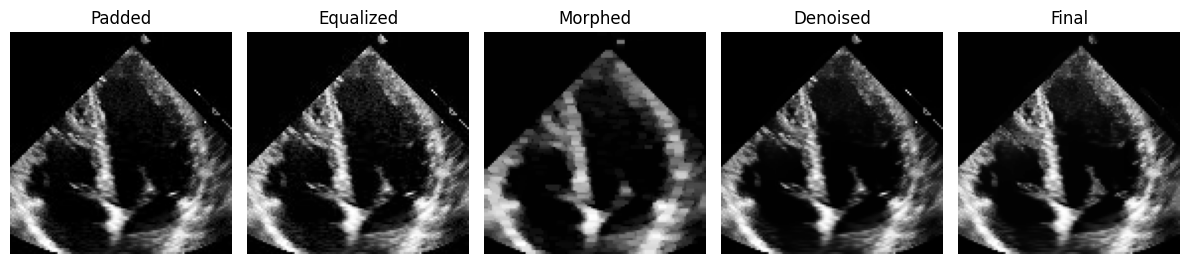

In [51]:
from matplotlib import pyplot as plt

def plot_images(images, titles, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(
    [padded_image, equalized_image, morphed_img, denoised_image_resized, denoised_image_final],
    ['Padded', 'Equalized', 'Morphed', 'Denoised', 'Final']
)
